In [1]:
'''try:
    import xclim
except ModuleNotFoundError:
    ! pip install xclim'''

'try:\n    import xclim\nexcept ModuleNotFoundError:\n    ! pip install xclim'

In [2]:
%matplotlib inline 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os 
import gcsfs 
from matplotlib import cm
import warnings 
import seaborn as sns
import yaml

from xclim.indicators import cf 
from xclim.indicators import icclim, atmos, anuclim

# from science_validation_manual import *
from dc6_functions import * 
from scipy.stats import kstest

import dask
import dask.array as da
import dask.distributed as dd
import rhg_compute_tools.kubernetes as rhgk

/tmp/ipykernel_11332/2716957755.py:25: DeprecationWarning: rhg_compute_tools and the associated command-line application rctools are
deprecated on catalyst clusters. use catalyst_compute_tools instead.
See https://gitlab.com/crs-catalyst/infrastructure/catalyst_compute_tools/-/issues/1
  import rhg_compute_tools.kubernetes as rhgk


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
# plot_dir = '/gcs/impactlab-data/climate/downscaling/paper/'
plot_dir = '/home/jovyan/paper_figures/'

In [5]:
models_dict = get_cmip6_models()
ensemble_members = get_cmip6_ensemble_members()
grids = get_cmip6_grids()
institutions = get_cmip6_institutions()
ds_institutions = get_cmip6_institutions()
ds_institutions['MPI-ESM1-2-HR'] = 'MPI-M'

In [6]:
institutions

{'BCC-CSM2-MR': 'BCC',
 'FGOALS-g3': 'CAS',
 'ACCESS-ESM1-5': 'CSIRO',
 'ACCESS-CM2': 'CSIRO-ARCCSS',
 'INM-CM4-8': 'INM',
 'INM-CM5-0': 'INM',
 'MIROC-ES2L': 'MIROC',
 'MIROC6': 'MIROC',
 'NorESM2-LM': 'NCC',
 'NorESM2-MM': 'NCC',
 'GFDL-ESM4': 'NOAA-GFDL',
 'GFDL-CM4': 'NOAA-GFDL',
 'NESM3': 'NUIST',
 'MPI-ESM1-2-HR': 'DKRZ',
 'HadGEM3-GC31-LL': 'MOHC',
 'UKESM1-0-LL': 'MOHC',
 'MPI-ESM1-2-LR': 'MPI-M',
 'CMCC-CM2-SR5': 'CMCC',
 'CMCC-ESM2': 'CMCC',
 'CanESM5': 'CCCma',
 'EC-Earth3': 'EC-Earth-Consortium',
 'EC-Earth3-AerChem': 'EC-Earth-Consortium',
 'EC-Earth3-CC': 'EC-Earth-Consortium',
 'EC-Earth3-Veg': 'EC-Earth-Consortium',
 'EC-Earth3-Veg-LR': 'EC-Earth-Consortium'}

In [7]:
# ds_institutions

In [8]:
# institutions

In [9]:
# client, cluster = rhgk.get_standard_cluster()

In [10]:
# cluster

In [11]:
with open('dcmip6_all_paths.yaml', 'r') as f:
    all_paths = yaml.safe_load(f)

In [12]:
def compute_etccdi(da, metric):
    """
    metric: {'summer_days', 'tropical_nights', 'wet_days', 'wet_days_thresh', 'annual_precip', 'seasonal_precip', 'seasonal_tasmax', 'seasonal_tasmin', 'days_over_95', 'frost_days', 'consecutive_dry_days'}
    """
    
    if metric == 'summer_days':
        return icclim.SU(da)
    elif metric == 'tropical_nights':
        return atmos.tn_days_above(da)
    elif metric == 'wet_days':
        return atmos.wetdays(da)
    elif metric == 'wet_days_thresh':
        return atmos.wetdays_prop(da, thresh='10.0 mm/day')
    elif metric == 'annual_precip':
        return anuclim.P12_AnnualPrecip(da)
    elif metric == 'seasonal_precip': 
        return da.resample(time='QS-DEC').sum()
    elif (metric == 'seasonal_tasmax') or (metric == 'seasonal_tasmin'):
        return da.resample(time='QS-DEC').mean()
    elif metric == 'frost_days':
        return atmos.frost_days(da) 
    elif metric == 'days_over_95': 
        return atmos.tx_days_above(da, thresh='35.0 degC')
    elif metric == 'days_over_90': 
        return atmos.tx_days_above(da, thresh='32.22 degC')
    elif metric == 'consecutive_dry_days':
        return atmos.maximum_consecutive_dry_days(da)
    

downscaled data for one model 

Select 4 "moderate extremes" indicators: 

- "summer days" (SU, Number of summer days: Annual count of days when TX (daily maximum temperature) > 25oC) `atmos.tx_days_above`
- number of tropical nights (TR, Number of tropical nights: Annual count of days when TN (daily minimum temperature) > 20oC) `atmos.tn_days_above`
- number of wet days (per year) `atmos.wetdays`
- number of days with precip > 10mm `atmos.wetdays_prop`
- annual total precip `anuclim.P12_AnnualPrecip`

In [13]:
models_dict

{'BCC-CSM2-MR': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
 'FGOALS-g3': ['historical', 'ssp245', 'ssp370', 'ssp585'],
 'ACCESS-ESM1-5': ['historical', 'ssp126', 'ssp245', 'ssp370'],
 'ACCESS-CM2': ['historical', 'ssp245', 'ssp370'],
 'INM-CM4-8': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
 'INM-CM5-0': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
 'MIROC-ES2L': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
 'MIROC6': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
 'NorESM2-LM': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
 'NorESM2-MM': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
 'GFDL-ESM4': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
 'GFDL-CM4': ['historical', 'ssp245', 'ssp585'],
 'NESM3': ['historical', 'ssp126', 'ssp245', 'ssp585'],
 'MPI-ESM1-2-HR': ['historical', 'ssp126', 'ssp585'],
 'HadGEM3-GC31-LL': ['historical', 'ssp126', 'ssp245', 'ssp585'],
 'UKESM1-0-LL': ['historical', 'ssp126

track which tests pass for which indices/models 

In [14]:
gcms_indices_calibration = {}
downscaled_indices_calibration = {}
gcms_indices_validation = {}
downscaled_indices_validation = {}

### look at calibration period ### 

In [15]:
city = 'Miami'

gcms_ks_calib = {}
downscaled_ks_calib = {}

# etccdis = ['summer_days', 'tropical_nights', 'wet_days', 'wet_days_thresh']
etccdis = ['summer_days', 'tropical_nights', 'wet_days', 'wet_days_thresh', 'annual_precip', 'seasonal_precip', 'seasonal_tasmax', 'seasonal_tasmin', 'days_over_95', 'frost_days', 'consecutive_dry_days', 'days_over_90']

# models = ['MPI-ESM1-2-HR', 'GFDL-CM4']

diag_type = 'city'
data_type = 'downscaled'
# model = 'GFDL-ESM4'

for model in models_dict.keys():
    # for model in models:
    print(model)
    gcm_tests = 0
    ds_tests = 0

    for etccdi in etccdis:

        if (etccdi == 'summer_days') or (etccdi == 'seasonal_tasmax') or (etccdi == 'days_over_95') or (etccdi == 'days_over_90'):
            variable = 'tasmax'
            var_name = 'tasmax'
        elif (etccdi == 'tropical_nights') or (etccdi == 'frost_days') or (etccdi == 'seasonal_tasmin'):
            variable = 'tasmin'
            var_name = 'tasmin'
        else: 
            variable = 'precip'
            var_name = 'pr'

        ref = load_zarr(get_diagnostics_filepath(diag_type, 'reanalysis', institutions, ensemble_members, variable, model, 'historical', validation_period=False)).sel(city=city)
        # print(get_diagnostics_filepath(diag_type, 'clean', institutions, ensemble_members, variable, model, 'historical'))
        gcm = load_zarr(get_diagnostics_filepath(diag_type, 'clean', institutions, ensemble_members, variable, model, 'historical')).sel(city=city)
        # print(get_diagnostics_filepath(diag_type, 'downscaled', institutions, ensemble_members, variable, model, 'historical'))
        downscaled = load_zarr(get_diagnostics_filepath(diag_type, 'downscaled', ds_institutions, ensemble_members, variable, model, 'historical')).sel(city=city)

        ks_test_gcm = kstest(compute_etccdi(ref[var_name].sel(time=slice('1995', '2014')), etccdi), 
                            compute_etccdi(gcm[var_name].sel(time=slice('1995', '2014')), etccdi))

        ks_test_downscaled = kstest(compute_etccdi(ref[var_name].sel(time=slice('1995', '2014')), etccdi), 
                            compute_etccdi(downscaled[var_name].sel(time=slice('1995', '2014')), etccdi))
        if ks_test_gcm[1] < 0.05:
            gcm_tests += 1
            gcms_indices_calibration[(model, etccdi)] = 1.0
        else: 
            gcms_indices_calibration[(model, etccdi)] = 0.0
        if ks_test_downscaled[1] < 0.05:
            ds_tests += 1
            downscaled_indices_calibration[(model, etccdi)] = 1.0
        else: 
            downscaled_indices_calibration[(model, etccdi)] = 0.0
    gcms_ks_calib[model] = gcm_tests
    downscaled_ks_calib[model] = ds_tests

BCC-CSM2-MR
FGOALS-g3
ACCESS-ESM1-5
ACCESS-CM2
INM-CM4-8
INM-CM5-0
MIROC-ES2L
MIROC6
NorESM2-LM
NorESM2-MM
GFDL-ESM4
GFDL-CM4
NESM3
MPI-ESM1-2-HR
HadGEM3-GC31-LL
UKESM1-0-LL
MPI-ESM1-2-LR
CMCC-CM2-SR5
CMCC-ESM2
CanESM5
EC-Earth3
EC-Earth3-AerChem
EC-Earth3-CC
EC-Earth3-Veg
EC-Earth3-Veg-LR


### compute the same but over the validation period ### 

For tasmax and tasmin, we have 1979 - 2020. For precip, we are missing 1983 and 2016 is buggy. Also precip is in m, needs to be converted. 

So for tasmax and tasmin, use 1979-1994. For precip, 1984 - 1994. Add split sample period later maybe. 

In [16]:
ref1 = load_zarr(get_diagnostics_filepath('city', 'reanalysis', institutions, ensemble_members, 'precip', 'BCC-CSM2-MR', 'historical', validation_period=True)).sel(city='Miami')
ref1['pr'] = ref1['pr'] * 1000 # conversion to mm 
ref1['pr'].attrs['units'] = 'mm day-1'
start_year = '1984'
end_year = '1994'

In [17]:
ref2 = load_zarr(get_diagnostics_filepath('city', 'reanalysis', institutions, ensemble_members, 'precip', 'BCC-CSM2-MR', 'historical')).sel(city='Miami')

In [18]:
u = compute_etccdi(ref1['pr'].sel(time=slice(start_year, end_year)), 'wet_days')
# ref['pr'].sel(time=slice(start_year, end_year))
# ref['pr']

In [20]:
# u

In [21]:
city = 'Miami'

gcms_ks_valid = {}
downscaled_ks_valid = {}

start_year = '1979'
end_year = '1994'

# etccdis = ['summer_days', 'tropical_nights', 'wet_days', 'wet_days_thresh']
etccdis = ['summer_days', 'tropical_nights', 'wet_days', 'wet_days_thresh', 'annual_precip', 'seasonal_precip', 'seasonal_tasmax', 'seasonal_tasmin', 'days_over_95', 'frost_days', 'consecutive_dry_days', 'days_over_90']

# models = ['MPI-ESM1-2-HR', 'GFDL-CM4']

diag_type = 'city'
data_type = 'downscaled'
# model = 'GFDL-ESM4'

for model in models_dict.keys():
    # for model in models:
    print(model)
    gcm_tests = 0
    ds_tests = 0

    for etccdi in etccdis:

        if (etccdi == 'summer_days') or (etccdi == 'seasonal_tasmax') or (etccdi == 'days_over_95') or (etccdi == 'days_over_90'):
            variable = 'tasmax'
            var_name = 'tasmax'
            start_year = '1979'
            end_year = '1994'
        elif (etccdi == 'tropical_nights') or (etccdi == 'frost_days') or (etccdi == 'seasonal_tasmin'):
            variable = 'tasmin'
            var_name = 'tasmin'
            start_year = '1979'
            end_year = '1994'
        else: 
            variable = 'precip'
            var_name = 'pr'
            start_year = '1984'
            end_year = '1994'

        ref = load_zarr(get_diagnostics_filepath(diag_type, 'reanalysis', institutions, ensemble_members, variable, model, 'historical', validation_period=True)).sel(city=city)
        # needs units for xclim 
        if variable == 'tasmax' or variable == 'tasmin':
            ref[var_name].attrs['units'] = 'K'
        else:
            ref[var_name] = ref[var_name] * 1000 # conversion to mm /day 
            ref[var_name].attrs['units'] = 'mm day-1'
        # print(get_diagnostics_filepath(diag_type, 'clean', institutions, ensemble_members, variable, model, 'historical'))
        gcm = load_zarr(get_diagnostics_filepath(diag_type, 'clean', institutions, ensemble_members, variable, model, 'historical')).sel(city=city)
        # print(get_diagnostics_filepath(diag_type, 'downscaled', institutions, ensemble_members, variable, model, 'historical'))
        downscaled = load_zarr(get_diagnostics_filepath(diag_type, 'downscaled', ds_institutions, ensemble_members, variable, model, 'historical')).sel(city=city)

        ks_test_gcm = kstest(compute_etccdi(ref[var_name].sel(time=slice(start_year, end_year)), etccdi), 
                            compute_etccdi(gcm[var_name].sel(time=slice(start_year, end_year)), etccdi))

        ks_test_downscaled = kstest(compute_etccdi(ref[var_name].sel(time=slice(start_year, end_year)), etccdi), 
                            compute_etccdi(downscaled[var_name].sel(time=slice(start_year, end_year)), etccdi))
        
        if ks_test_gcm[1] < 0.05:
            gcm_tests += 1
            gcms_indices_validation[(model, etccdi)] = 1.0
        else: 
            gcms_indices_validation[(model, etccdi)] = 0.0
        if ks_test_downscaled[1] < 0.05:
            ds_tests += 1
            downscaled_indices_validation[(model, etccdi)] = 1.0
        else: 
            downscaled_indices_validation[(model, etccdi)] = 0.0
    
    gcms_ks_valid[model] = gcm_tests
    downscaled_ks_valid[model] = ds_tests

BCC-CSM2-MR
FGOALS-g3
ACCESS-ESM1-5
ACCESS-CM2
INM-CM4-8
INM-CM5-0
MIROC-ES2L
MIROC6
NorESM2-LM
NorESM2-MM
GFDL-ESM4
GFDL-CM4
NESM3
MPI-ESM1-2-HR
HadGEM3-GC31-LL
UKESM1-0-LL
MPI-ESM1-2-LR
CMCC-CM2-SR5
CMCC-ESM2
CanESM5
EC-Earth3
EC-Earth3-AerChem
EC-Earth3-CC
EC-Earth3-Veg
EC-Earth3-Veg-LR


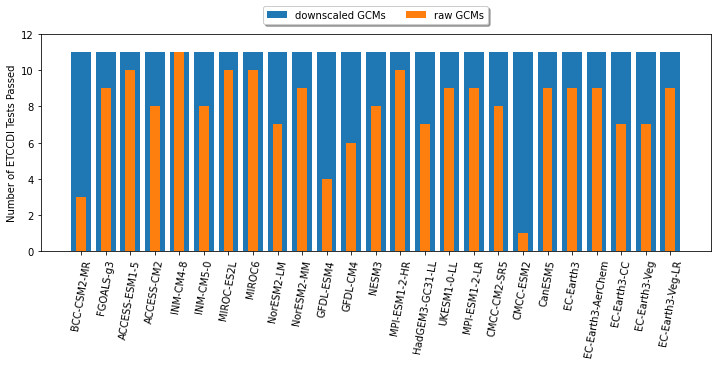

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.bar(*zip(*downscaled_ks_calib.items()), width=0.8, linewidth=0.4, align='center', label='downscaled GCMs')
axes.bar(*zip(*gcms_ks_calib.items()), width=0.4, linewidth=0.4, align='center', label='raw GCMs')
plt.xticks(rotation=80)
axes.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=2, fancybox=True, shadow=True)
axes.set_ylabel('Number of ETCCDI Tests Passed')
axes.set_ylim([0, 12])

plt.savefig(os.path.join(plot_dir, 'miami_etccdi_indices_calibration_MORE.png'), 
            bbox_inches='tight', dpi=200)

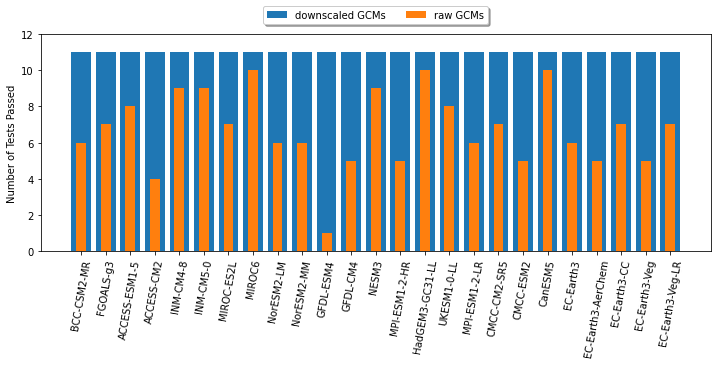

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.bar(*zip(*downscaled_ks_valid.items()), width=0.8, linewidth=0.4, align='center', label='downscaled GCMs')
axes.bar(*zip(*gcms_ks_valid.items()), width=0.4, linewidth=0.4, align='center', label='raw GCMs')
plt.xticks(rotation=80)
axes.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=2, fancybox=True, shadow=True)
axes.set_ylabel('Number of Tests Passed')
axes.set_ylim([0, 12])

plt.savefig(os.path.join(plot_dir, 'miami_etccdi_indices_validation_MORE.png'), 
            bbox_inches='tight', dpi=200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


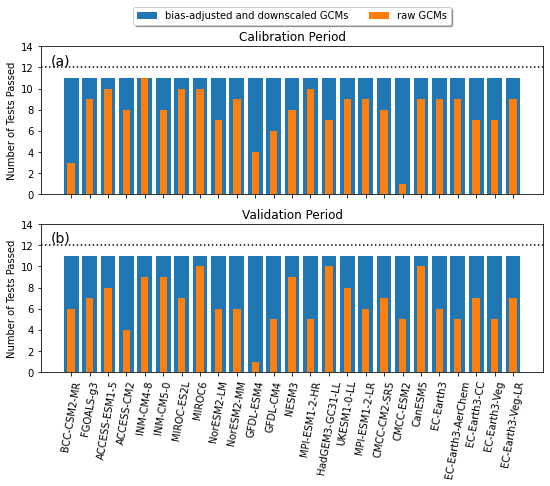

In [48]:
fig, axes = plt.subplots(2, 1, figsize=(9, 6))

axes[0].bar(*zip(*downscaled_ks_calib.items()), width=0.8, linewidth=0.4, align='center', label='bias-adjusted and downscaled GCMs')
axes[0].bar(*zip(*gcms_ks_calib.items()), width=0.4, linewidth=0.4, align='center', label='raw GCMs')
axes[0].axhline(y=12, linestyle=':', color='k')
axes[0].text(0.02, 0.95, '(a)', transform=axes[0].transAxes, fontsize=14, va='top')

axes[1].bar(*zip(*downscaled_ks_valid.items()), width=0.8, linewidth=0.4, align='center', label='bias-adjusted and downscaled GCMs')
axes[1].bar(*zip(*gcms_ks_valid.items()), width=0.4, linewidth=0.4, align='center', label='raw GCMs')
axes[1].axhline(y=12, linestyle=':', color='k')
axes[1].text(0.02, 0.95, '(b)', transform=axes[1].transAxes, fontsize=14, va='top')

plt.setp( axes[0].get_xticklabels(), visible=False)
axes[1].set_xticklabels(downscaled_ks_valid.keys(), rotation=80)

axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=2, fancybox=True, shadow=True)
axes[0].set_title('Calibration Period')
axes[1].set_title('Validation Period')
axes[0].set_ylabel('Number of Tests Passed')
axes[1].set_ylabel('Number of Tests Passed')
axes[1].set_ylim([0, 14])
axes[0].set_ylim([0, 14])

# fix for saving as EPS (bug: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.)
# axes[0].set_rasterized(True)
# axes[1].set_rasterized(True)
plt.savefig(os.path.join(plot_dir, 'miami_etccdi_indices_calib_and_valid.eps'), 
            bbox_inches='tight', dpi=300, format='eps')

which test doesn't pass for any model? hypothesis is consecutive dry days 

In [ ]:
city = 'Miami'

gcms_ks_calib = {}
downscaled_ks_calib = {}

etccdis = ['frost_days']
'''etccdis = ['summer_days', 'tropical_nights', 'wet_days', 'wet_days_thresh', 'annual_precip', 'seasonal_precip', 'seasonal_tasmax', 'seasonal_tasmin', 'days_over_95', 'frost_days', 'consecutive_dry_days', 'days_over_90']'''

models = ['GFDL-CM4']

diag_type = 'city'
data_type = 'downscaled'
# model = 'GFDL-ESM4'

# for model in models_dict.keys():
for model in models:
    print(model)
    gcm_tests = 0
    ds_tests = 0

    for etccdi in etccdis:

        if (etccdi == 'summer_days') or (etccdi == 'seasonal_tasmax') or (etccdi == 'days_over_95') or (etccdi == 'days_over_90'):
            variable = 'tasmax'
            var_name = 'tasmax'
        elif (etccdi == 'tropical_nights') or (etccdi == 'frost_days') or (etccdi == 'seasonal_tasmin'):
            variable = 'tasmin'
            var_name = 'tasmin'
        else: 
            variable = 'precip'
            var_name = 'pr'

        ref = load_zarr(get_diagnostics_filepath(diag_type, 'reanalysis', institutions, ensemble_members, variable, model, 'historical', validation_period=False)).sel(city=city)
        # print(get_diagnostics_filepath(diag_type, 'clean', institutions, ensemble_members, variable, model, 'historical'))
        gcm = load_zarr(get_diagnostics_filepath(diag_type, 'clean', institutions, ensemble_members, variable, model, 'historical')).sel(city=city)
        # print(get_diagnostics_filepath(diag_type, 'downscaled', institutions, ensemble_members, variable, model, 'historical'))
        downscaled = load_zarr(get_diagnostics_filepath(diag_type, 'downscaled', ds_institutions, ensemble_members, variable, model, 'historical')).sel(city=city)

        ks_test_gcm = kstest(compute_etccdi(ref[var_name].sel(time=slice('1995', '2014')), etccdi), 
                            compute_etccdi(gcm[var_name].sel(time=slice('1995', '2014')), etccdi))

        ks_test_downscaled = kstest(compute_etccdi(ref[var_name].sel(time=slice('1995', '2014')), etccdi), 
                            compute_etccdi(downscaled[var_name].sel(time=slice('1995', '2014')), etccdi))
        if ks_test_gcm[1] < 0.05:
            gcm_tests += 1
        if ks_test_downscaled[1] < 0.05:
            ds_tests += 1
    gcms_ks_calib[model] = gcm_tests
    downscaled_ks_calib[model] = ds_tests

In [ ]:
ks_test_gcm

In [ ]:
ks_test_downscaled

In [ ]:
compute_etccdi(gcm[var_name].sel(time=slice('1995', '2014')), 'frost_days').values

### it's frost days that never passes ### 

### make heatmap with passing/failing tests ### 

In [ ]:
# gcms_indices_calibration

In [ ]:
import pandas as pd
import seaborn as sns
ser_gcms_calibration = pd.Series(list(gcms_indices_calibration.values()),
                  index=pd.MultiIndex.from_tuples(gcms_indices_calibration.keys()))
ser_gcms_validation = pd.Series(list(gcms_indices_validation.values()),
                  index=pd.MultiIndex.from_tuples(gcms_indices_validation.keys()))
ser_ds_calibration = pd.Series(list(downscaled_indices_calibration.values()),
                  index=pd.MultiIndex.from_tuples(downscaled_indices_calibration.keys()))
df_gcms_calibration = ser_gcms_calibration.unstack()
df_gcms_validation = ser_gcms_validation.unstack()
df_downscaled_calibration = ser_ds_calibration.unstack()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
cmap = 'Reds'
sns.heatmap(df_gcms_calibration.T, ax=axes[0], cmap=cmap)
sns.heatmap(df_gcms_validation.T, ax=axes[1], cmap=cmap)

In [ ]:
# df_gcms_calibration